In [ ]:
# ==========================================
# Ventilation Fan Fault Training with per-batch reporting
# ==========================================


: 

__________________________________________________________
__________________________________________________________


In [ ]:
#main architecture

#import
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
import random, os
import matplotlib.pyplot as plt

# -----------------------------
# Seed
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -----------------------------
# 1. Load and preprocess data
# -----------------------------
df = pd.read_excel("ventilation_fan_faults_data.xlsx")

y = df['state']
X = df.drop(columns=['state'])

X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Data shapes -> Train:", X_train_scaled.shape, " Test:", X_test_scaled.shape)

# -----------------------------
# 2. Define Model
# -----------------------------
class MLP_RBF_Nto2(nn.Module):
    def __init__(self, input_dim, hidden_size=9, num_classes=3):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_dim),
            nn.Sigmoid()
        )
        self.centers = nn.Parameter(torch.zeros(input_dim))
        self.log_sigmas = nn.Parameter(torch.zeros(input_dim))
        self.to_latent = nn.Linear(input_dim, 2)
        self.classifier = nn.Linear(2, num_classes)
    
    def forward(self, x):
        # 1. خروجی MLP (0,1)
        gates = self.mlp(x)          # gates ∈ [0,1]

        # 2. ضرب فیچرها در ماسک
        x_weighted = x * gates

        # 3. محاسبه RBF روی فیچر وزن‌دار
        sigmas = torch.exp(self.log_sigmas).clamp(min=1e-2, max=5.0)
        dist2 = ((x_weighted - self.centers) / sigmas) ** 2
        dist2 = torch.clamp(dist2, 0.0, 50.0)
        rbf = torch.exp(-0.5 * dist2)

        # 4. نگاشت به فضای ۲بعدی و پیش‌بینی
        z = self.to_latent(rbf)
        logits = self.classifier(z)
        return logits, z, rbf, sigmas


# -----------------------------
# 3. Training Loop with per-batch reporting
# -----------------------------
def train_model(model, X_train, y_train, X_val, y_val,
                lr=1e-4, epochs=100, batch_size=64):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    n = len(X_train)

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb, yb = X_train[idx].to(device), y_train[idx].to(device)

            logits, z, rbf, sigmas = model(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # ---- per batch reporting ----
            preds = logits.argmax(dim=1).cpu().numpy()
            f1 = f1_score(yb.cpu().numpy(), preds, average="macro")

            print(f"Epoch {epoch+1:03d} | Batch {i//batch_size+1:03d} "
                  f"| loss={loss.item():.4f} | f1={f1:.4f}")
            print("  centers:", model.centers.detach().cpu().numpy())
            print("  sigmas :", sigmas.detach().cpu().numpy())

            # Scatter plot of latent features
            z_np = z.detach().cpu().numpy()
            yb_np = yb.cpu().numpy()
            #plt.figure(figsize=(5,4))
            #scatter = plt.scatter(z_np[:,0], z_np[:,1],
                                  #c=yb_np, cmap="tab10", alpha=0.8, edgecolors="k")
  

        # ---- Validation at end of epoch ----
 
        model.eval()
        with torch.no_grad():
            # --- Validation ---
            logits_val, z_val, _, _ = model(X_val.to(device))
            preds_val = logits_val.argmax(dim=1).cpu().numpy()
            f1_val = f1_score(y_val.numpy(), preds_val, average="macro")

            # --- Train ---
            logits_train, _, _, _ = model(X_train.to(device))
            preds_train = logits_train.argmax(dim=1).cpu().numpy()
            f1_train = f1_score(y_train.numpy(), preds_train, average="macro")

        print(f"[Validation] Epoch {epoch+1:03d} | f1={f1_val:.4f}")
        print(f"[Train]      Epoch {epoch+1:03d} | f1={f1_train:.4f}")
# -----------------------------
# 4. Run Training
# -----------------------------
input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y))

model = MLP_RBF_Nto2(input_dim=input_dim, hidden_size=9, num_classes=num_classes)

train_model(
    model,
    X_train_scaled, y_train,
    X_test_scaled,  y_test,
    lr=1e-3,
    epochs=100,   
    batch_size=64
)


__________________________________________________________
__________________________________________________________


<p style="text-align: right;">
نشان دهنده روند یادگیری درهر ایپاک 
به این شکل که اول شبکه به طور مستقل با یه ایپاک ترین شده بعد با دوتا و همنینطوری تا اخر
</p>



In [ ]:
results = []

for i in range(1, 21):  # تعداد epoch های آزمایشی از 1 تا 20
    model = MLP_RBF_Nto2(input_dim=input_dim, hidden_size=9, num_classes=num_classes)

    # لیست برای ذخیره log هر epoch
    epoch_logs = []

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor   = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_val_tensor   = torch.tensor(y_test, dtype=torch.long).to(device)

    n = len(X_train_tensor)
    batch_size = 64

    for epoch in range(i):  # آموزش تا i epoch
        model.train()
        perm = torch.randperm(n)
        for j in range(0, n, batch_size):
            idx = perm[j:j+batch_size]
            xb, yb = X_train_tensor[idx], y_train_tensor[idx]

            logits, _, _, _ = model(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # محاسبه F1 و ذخیره centers و sigmas
        model.eval()
        with torch.no_grad():
            logits_val, _, _, sigmas_val = model(X_val_tensor)
            preds_val = logits_val.argmax(dim=1).cpu().numpy()
            f1_val = f1_score(y_test, preds_val, average="macro")

            logits_train, _, _, sigmas_train = model(X_train_tensor)
            preds_train = logits_train.argmax(dim=1).cpu().numpy()
            f1_train = f1_score(y_train, preds_train, average="macro")

            centers_np = model.centers.detach().cpu().numpy()
            sigmas_np  = torch.exp(model.log_sigmas).detach().cpu().numpy()

        epoch_logs.append({
            "epoch": epoch+1,
            "f1_train": f1_train,
            "f1_val": f1_val,
            "centers": centers_np,
            "sigmas": sigmas_np
        })

    # آخرین epoch برای این run
    last_log = epoch_logs[-1]
    last_log["trained_epochs"] = i
    results.append(last_log)

# تبدیل به DataFrame و ذخیره
df_results = pd.DataFrame(results)
print(df_results)
df_results.to_excel("F1_centers_sigmas.xlsx", index=False)


In [ ]:
results = []

for i in range(1, 101,9):  # تعداد epoch های آزمایشی از 1 تا 20
    model = MLP_RBF_Nto2(input_dim=input_dim, hidden_size=9, num_classes=num_classes)

    # لیست برای ذخیره log هر epoch
    epoch_logs = []

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor   = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_val_tensor   = torch.tensor(y_test, dtype=torch.long).to(device)

    n = len(X_train_tensor)
    batch_size = 64

    for epoch in range(i):  # آموزش تا i epoch
        model.train()
        perm = torch.randperm(n)
        for j in range(0, n, batch_size):
            idx = perm[j:j+batch_size]
            xb, yb = X_train_tensor[idx], y_train_tensor[idx]

            logits, _, _, _ = model(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # محاسبه F1 و ذخیره centers و sigmas
        model.eval()
        with torch.no_grad():
            logits_val, _, _, sigmas_val = model(X_val_tensor)
            preds_val = logits_val.argmax(dim=1).cpu().numpy()
            f1_val = f1_score(y_test, preds_val, average="macro")

            logits_train, _, _, sigmas_train = model(X_train_tensor)
            preds_train = logits_train.argmax(dim=1).cpu().numpy()
            f1_train = f1_score(y_train, preds_train, average="macro")

            centers_np = model.centers.detach().cpu().numpy()
            sigmas_np  = torch.exp(model.log_sigmas).detach().cpu().numpy()

        epoch_logs.append({
            "epoch": epoch+1,
            "f1_train": f1_train,
            "f1_val": f1_val,
            "centers": centers_np,
            "sigmas": sigmas_np
        })

    # آخرین epoch برای این run
    last_log = epoch_logs[-1]
    last_log["trained_epochs"] = i
    results.append(last_log)

# تبدیل به DataFrame و ذخیره
df_results = pd.DataFrame(results)
print(df_results)
df_results.to_excel("F1_centers_sigmas_100.xlsx", index=False)


__________________________________________________________
__________________________________________________________


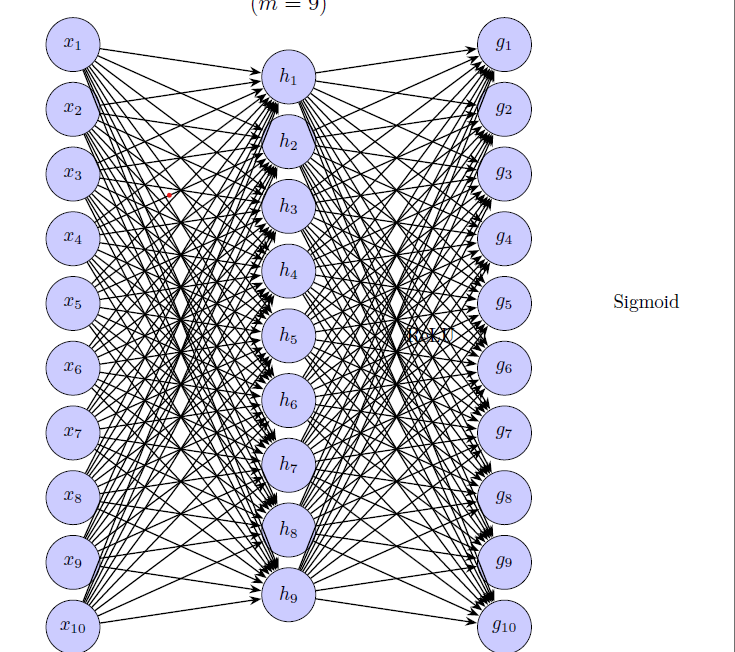

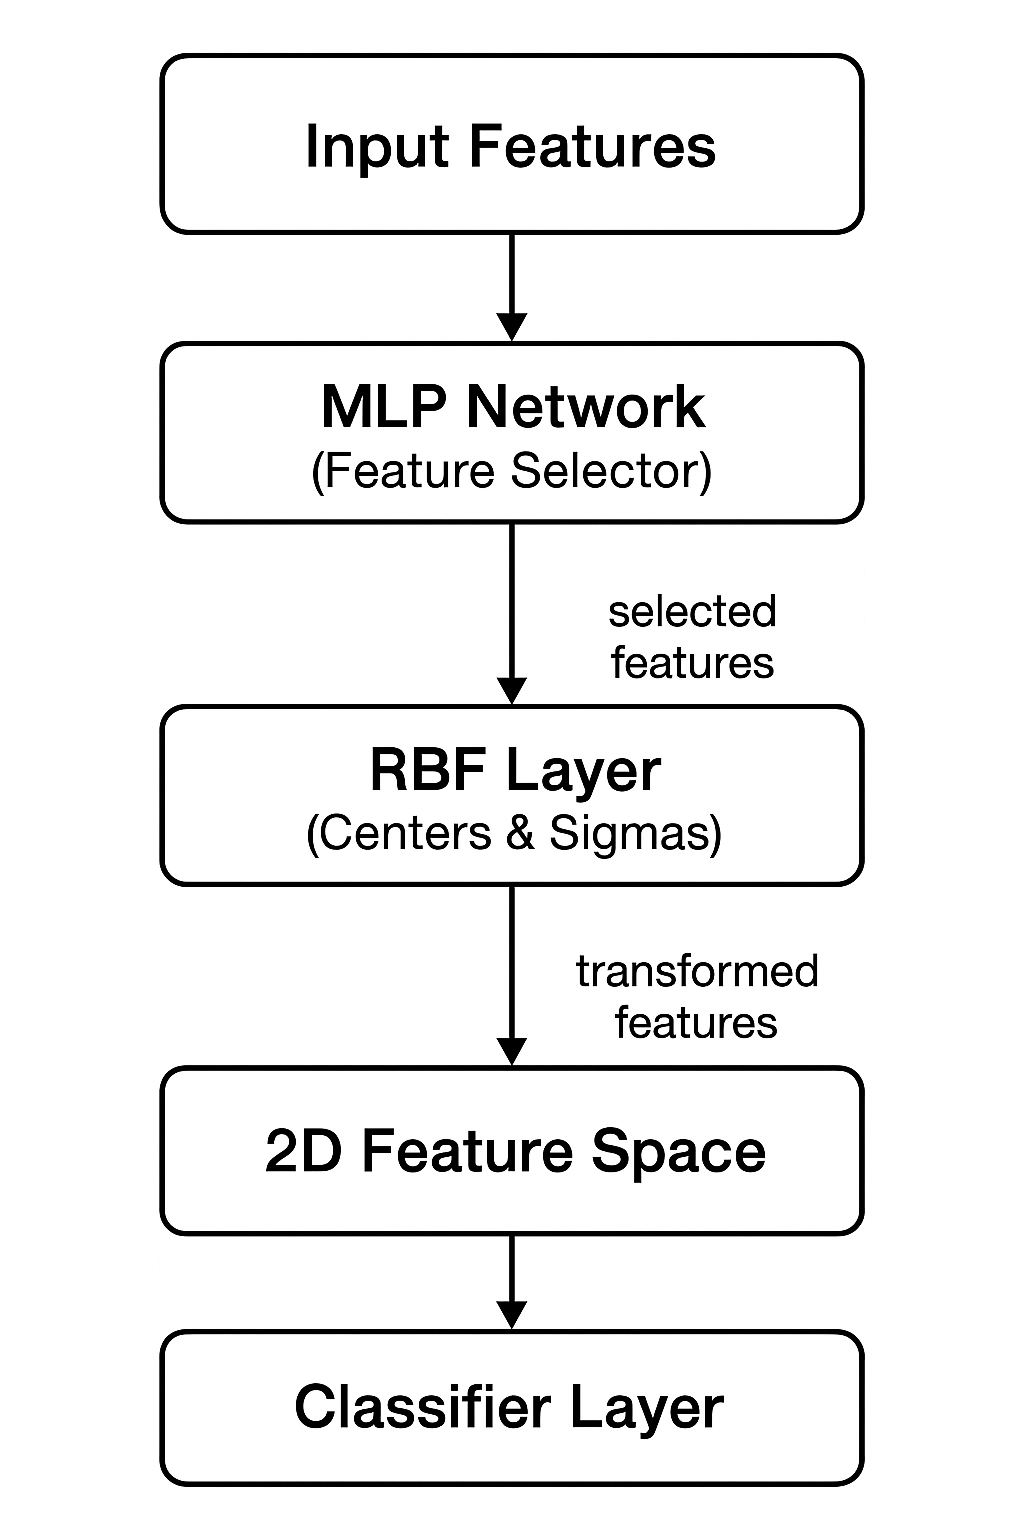

In [ ]:
#again model and plot

#import
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
import random, os
import matplotlib.pyplot as plt

# -----------------------------
# Seed
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -----------------------------
# 1. Load and preprocess data
# -----------------------------
df = pd.read_excel("ventilation_fan_faults_data.xlsx")

y = df['state']
X = df.drop(columns=['state'])

X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Data shapes -> Train:", X_train_scaled.shape, " Test:", X_test_scaled.shape)

# -----------------------------
# 2. Define Model
# -----------------------------
class MLP_RBF_Nto2(nn.Module):
    def __init__(self, input_dim, hidden_size=9, num_classes=3):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_dim),
            nn.Sigmoid()
        )
        self.centers = nn.Parameter(torch.zeros(input_dim))
        self.log_sigmas = nn.Parameter(torch.zeros(input_dim))
        self.to_latent = nn.Linear(input_dim, 2)
        self.classifier = nn.Linear(2, num_classes)
    
    def forward(self, x):
        # 1. خروجی MLP (0,1)
        gates = self.mlp(x)          # gates ∈ [0,1]

        # 2. ضرب فیچرها در ماسک
        x_weighted = x * gates

        # 3. محاسبه RBF روی فیچر وزن‌دار
        sigmas = torch.exp(self.log_sigmas).clamp(min=1e-2, max=5.0)
        dist2 = ((x_weighted - self.centers) / sigmas) ** 2
        dist2 = torch.clamp(dist2, 0.0, 50.0)
        rbf = torch.exp(-0.5 * dist2)

        # 4. نگاشت به فضای ۲بعدی و پیش‌بینی
        z = self.to_latent(rbf)
        logits = self.classifier(z)
        return logits, z, rbf, sigmas



# -----------------------------
# 3. Training + Logging
# -----------------------------
def train_and_log(model, X_train, y_train, X_val, y_val,
                  lr=1e-3, epochs=30, batch_size=64):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)

    history = {"epoch": [], "f1_train": [], "f1_val": [],
               "centers": [], "sigmas": []}

    n = len(X_train_t)

    for epoch in range(1, epochs+1):
        model.train()
        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb, yb = X_train_t[idx], y_train_t[idx]

            logits, _, _, _ = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # ---- Validation ----
        model.eval()
        with torch.no_grad():
            logits_train, _, _, _ = model(X_train_t)
            preds_train = logits_train.argmax(dim=1)
            f1_train = f1_score(y_train_t.cpu(), preds_train.cpu(), average="macro")

            logits_val, _, _, _ = model(X_val_t)
            preds_val = logits_val.argmax(dim=1)
            f1_val = f1_score(y_val_t.cpu(), preds_val.cpu(), average="macro")

        # ذخیره تاریخچه
        history["epoch"].append(epoch)
        history["f1_train"].append(f1_train)
        history["f1_val"].append(f1_val)
        history["centers"].append(model.centers.detach().cpu().numpy().copy())
        history["sigmas"].append(torch.exp(model.log_sigmas).detach().cpu().numpy().copy())

        print(f"Epoch {epoch:03d} | F1 Train={f1_train:.4f} | F1 Val={f1_val:.4f}")

    return history

# -----------------------------
# 4. Run Training
# -----------------------------
model = MLP_RBF_Nto2(input_dim=input_dim, hidden_size=9, num_classes=num_classes)
history = train_and_log(model, X_train_scaled, y_train, X_test_scaled, y_test,
                        lr=1e-3, epochs=30, batch_size=64)

# -----------------------------
# 5. Plot Results
# -----------------------------
# F1 Scores
plt.figure(figsize=(24,12))
plt.plot(history["epoch"], history["f1_train"], marker='o', label="F1 Train")
plt.plot(history["epoch"], history["f1_val"], marker='s', label="F1 Val")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score per Epoch")
plt.grid(True)
plt.legend()
plt.show()

#

import matplotlib.pyplot as plt
import numpy as np

# تبدیل لیست‌ها به آرایه numpy
centers_array = np.array(history["centers"])  # shape: (epochs, num_features)
sigmas_array  = np.array(history["sigmas"])   # shape: (epochs, num_features)
epochs = history["epoch"]

# ---- Centers ----
plt.figure(figsize=(24,12))
for i in range(centers_array.shape[1]):
    plt.plot(epochs, centers_array[:, i], label=f"Feature {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Center values")
plt.title("Centers vs Epoch")
plt.grid(True)
plt.legend()
plt.show()

# ---- Sigmas ----
plt.figure(figsize=(24,12))
for i in range(sigmas_array.shape[1]):
    plt.plot(epochs, sigmas_array[:, i], label=f"Feature {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Sigma values")
plt.title("Sigmas vs Epoch")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# بارگذاری دیتای اصلی
df = pd.read_excel("ventilation_fan_faults_data.xlsx")

# جدا کردن y و X
y = df['state']
X = df.drop(columns=['state'])

# فقط ستون‌های عددی (برای مدل)
X_num = X.apply(pd.to_numeric, errors='coerce')
X_num = X_num.fillna(X_num.mean())

# نرمال‌سازی
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# لیبل انکودینگ
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# استخراج فیچرهای جدید از مدل آموزش‌دیده
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
X_t = torch.tensor(X_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    _, z, _, _ = model(X_t)

z_np = z.cpu().numpy()

# اضافه کردن فیچرهای جدید به دیتای اصلی (دست‌نخورده)
df_out = df.copy()
df_out["z1"] = z_np[:, 0]
df_out["z2"] = z_np[:, 1]

# ذخیره
df_out.to_csv("ventilation_fan_with_features.csv", index=False, encoding="utf-8-sig")
print("✅ فایل ventilation_fan_with_features.csv ساخته شد.")


In [ ]:
#compare with pca and tsne

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("new_features.xlsx")  

labels = df['state']
feature1 = df['z1'] 
feature2 = df['z2']  

# 3. Plot
plt.figure(figsize=(8,6))
for lbl in labels.unique():
    idx = labels == lbl
    plt.scatter(feature1[idx], feature2[idx], label=str(lbl), s=50, alpha=0.7)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Feature1 vs Feature2 colored by Label")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

df = pd.read_excel("ventilation_fan_faults_data.xlsx")   

features = df.drop(columns=['state'])
labels = df['state']

# 3. Convert all feature columns to numeric (force errors to NaN)
features = features.apply(pd.to_numeric, errors='coerce')

# 4. Drop rows with NaN values
features = features.dropna()
labels = labels[features.index]  # keep only corresponding labels

# 5. Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 6. PCA to reduce to 2 components
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# 7. t-SNE 2D
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# PCA plot
for lbl in labels.unique():
    idx = labels == lbl
    axes[0].scatter(features_pca[idx, 0], features_pca[idx, 1], label=str(lbl), alpha=0.7, s=50)
axes[0].set_title("PCA 2D Projection")
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("PCA2")
axes[0].legend()
axes[0].grid(True)

# t-SNE plot
for lbl in labels.unique():
    idx = labels == lbl
    axes[1].scatter(features_tsne[idx, 0], features_tsne[idx, 1], label=str(lbl), alpha=0.7, s=50)
axes[1].set_title("t-SNE 2D Projection")
axes[1].set_xlabel("t-SNE Dim 1")
axes[1].set_ylabel("t-SNE Dim 2")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_excel("ventilation_fan_faults_data.xlsx")

# 2. Separate features and labels
features = df.drop(columns=['state'])
labels = df['state']

# 3. Convert all feature columns to numeric (force errors to NaN)
features = features.apply(pd.to_numeric, errors='coerce')

# 4. Drop rows with NaN values
features = features.dropna()
labels = labels[features.index]  # keep only corresponding labels

# 5. Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 6. Apply SVD for dimensionality reduction to 2D
svd = TruncatedSVD(n_components=2, random_state=42)
features_svd = svd.fit_transform(features_scaled)

# 7. Increase font sizes globally
plt.rcParams.update({'font.size': 14})

# 8. Plot the 2D projection
plt.figure(figsize=(9,8))
for lbl in labels.unique():
    idx = labels == lbl
    plt.scatter(features_svd[idx, 0], features_svd[idx, 1],
                label=str(lbl), alpha=0.7, s=70)

plt.title("SVD 2D Projection", fontsize=20)
plt.xlabel("SVD Component 1", fontsize=16)
plt.ylabel("SVD Component 2", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Auto encoder model
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_size=20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)   # latent space 2D
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z
    
# Training loop
def train_autoencoder(model, X_train, X_val, lr=1e-3, epochs=100, batch_size=64):
    device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)

    n = len(X_train)

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb = X_train[idx].to(device)

            x_recon, z = model(xb)
            loss = criterion(x_recon, xb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            x_recon_val, z_val = model(X_val.to(device))
            val_loss = criterion(x_recon_val, X_val.to(device))

        print(f"Epoch {epoch+1:03d} | Train Loss={loss.item():.4f} | Val Loss={val_loss.item():.4f}")
# Run training
input_dim = X_train_scaled.shape[1]
autoencoder = AutoEncoder(input_dim=input_dim, hidden_size=9)
train_autoencoder(autoencoder, X_train_scaled, X_test_scaled, lr=1e-3, epochs=100, batch_size=64)
# Visualize latent space
def plot_latent_space_autoencoder(model, X, y, title="Autoencoder Latent Space"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        _, z = model(X_t)
    z_np = z.cpu().numpy()

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(z_np[:,0], z_np[:,1], c=y, cmap="tab10", alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.title(title)
    plt.grid(True)
    plt.show()
plot_latent_space_autoencoder(autoencoder, X_test_scaled, y_test)